In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from Geometry_Free import Geometry_Free
from Geometry_Grid import Geometry_Grid
from Definitions import get_datafolder

basefolder = get_datafolder()+'/'

def labelEvaluation(labels, labels_groundtruth, min_overlap_per_ref = 0.5 ):

    """
    Evaluate the labeling performed by the algorithm, comparing it with the ground truth provided
    by the `Geometry` object.

    Returns
    -------
    clusters_correct: np.array

    """

    no_clusters = np.max(labels) + 1
    no_clusters_gT = np.max(labels_groundtruth) + 1

    clusters_correct = -np.ones((no_clusters,), dtype=np.int)

    clusters = [np.where(labels == i)[0] for i in np.arange(no_clusters)]
    clusters_ref = [np.where(labels_groundtruth == i)[0] for i in np.arange(no_clusters_gT)]

    for i, cl in enumerate(clusters):
        coverage = 0
        idx_chosen = -1
        for ii, cl_ref in enumerate(clusters_ref):
            cl_and_clRef = np.intersect1d(cl, cl_ref)
            clusters_correct[i] = -1
            if len(cl_and_clRef) > min_overlap_per_ref * len(cl_ref):
                if (len(cl_and_clRef) / len(cl)) > coverage:
                    idx_chosen = ii
                    coverage = len(cl_and_clRef) / len(cl)

        clusters_ref = [clusters_ref[i] for i in np.arange(len(clusters_ref)) if (i != idx_chosen)]
        clusters_correct[i] = idx_chosen

    return clusters_correct


def clusterEvaluation(labels, labels_groundtruth):
    """
    Evaluate the performance of the clustering algorithm.

    This is done considering `Clustering.clusters_correct' computed by 'Clustering.__labelEvaluation`.

    Returns
    -------

    cluster_evaluation: dict
        * A dictionary containing:
        * true_positives
        * false_positives
        * false_negatives
        * n_groundtruth
        * false_negative_clusters
        * false_positive_clusters
        * true_positive_clusters
    """

    clusters_correct = labelEvaluation(labels, labels_groundtruth)

    n_groundtruth = np.max((labels_groundtruth)) + 1
    n_identified = np.max((labels)) + 1

    true_positives = np.sum(clusters_correct != -1)
    false_positives = np.sum(clusters_correct == -1)
    false_negatives = n_groundtruth - true_positives

    all_groundtruth = np.arange(n_groundtruth)
    all_identified = np.arange(n_identified)

    false_negative_clusters = np.asarray([a for a in all_groundtruth if (not (a in list(clusters_correct)))])
    false_positive_clusters = np.asarray([i for i in all_identified if (clusters_correct[i] == -1)])
    true_positive_clusters = np.asarray([i for i in all_identified if (clusters_correct[i] != -1)])

    cluster_evaluation = {"true_positives": true_positives,
                          "false_positives": false_positives,
                          "false_negatives": false_negatives,
                          "n_groundtruth": n_groundtruth,
                          "false_negative_clusters": false_negative_clusters,
                          "false_positive_clusters": false_positive_clusters,
                          "true_positive_clusters": true_positive_clusters}
    # COMPUTE
    return cluster_evaluation

def plot_clustering(XC, labels):
    plt.figure();
    mark = (labels == -1);
    sns.scatterplot(x=XC[mark, 0], y=XC[mark, 1], color='grey', s = 5, alpha=1);
    mark = (labels >= 0);
    sns.scatterplot(x=XC[mark, 0], y=XC[mark, 1], hue=labels[mark], palette='bright', s=5, legend=False);
    plt.axis('equal')
    
    
def subClustersPerRefCluster(labels,labels_groundTruth):
    """
    Returns
    -------
    number_of_subclusters : ndarray
    Entry `i` is how many subclusters reference cluster `i` is divided into
    """
    # Return an array. Entry i is how many subclusters reference cluster
    # i is devided into

    n_cl = np.max(labels_groundTruth)
    number_of_subclusters = np.zeros((n_cl + 1,))
    for idx_ref in np.unique(labels_groundTruth):
        if (idx_ref == -1): continue
        # Get the points
        mark = ((labels_groundTruth == idx_ref) * (labels != -1))
        number_of_subclusters[idx_ref] = len(np.unique(labels[mark]))
                                                
    return number_of_subclusters


def locEvaluation(labels,labels_groundTruth):

    """
    An evaluation performed point by point (instead of comparing clusters).

    Returns
    -------
    dict
        A dict with
        * `true_positives`
        * `false_positives`
        * `false_negatives`
    """


    false_positives = np.sum((labels != -1) * (labels_groundTruth == -1))
    false_negatives = np.sum((labels == -1) * (labels_groundTruth != -1))
    true_positives = np.sum((labels != -1) * (labels_groundTruth != -1))

    loc_evaluation = {"true_positives": true_positives,
                      "false_positives": false_positives,
                      "false_negatives": false_negatives}

    return loc_evaluation

def get_labels(sigma_idx,threshold_idx, PS):
    
    sigmas = np.unique(PS["sigma"])
    thresholds = np.unique(PS["threshold"])
    rslt_df = PS.loc[(PS['sigma'] == sigmas[sigma_idx]) &
              (PS['threshold'] == thresholds[threshold_idx])]
    
    print ("sigma = ",sigmas[sigma_idx], " threshold = ", thresholds[threshold_idx] )

    return rslt_df.labels.to_numpy()[0]

-----------------------------------
# PARAMETERS
-----------------------------------

In [15]:
log_sigmas = True
log_thresholds = False
adaptive_sigma_boundaries = False

dataset_number = 2
noise_ratio = 0.1
n_side = 5

geometry = "free" 
#geometry = "grid"

-----------------
# EXECUTION
-----------------

Loaded 25 template clusters..
Loaded 25 template clusters..


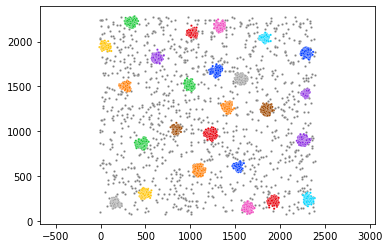

In [17]:
data_sets = ["Clusters_Neuron", #0 
             "Clusters_DNA_1mers",#1
            "Clusters_DNA_3mers", #2
             "Clusters_DNA_4mers"]#3


if geometry == "grid":
    G = Geometry_Grid(basefolder, data_sets[dataset_number],n_side=n_side, noise_ratio = noise_ratio,Delta_ratio=1.5)
elif geometry == "free":
    G = Geometry_Free(basefolder, data_sets[dataset_number], noise_ratio = noise_ratio, n_side = n_side, Delta_ratio = 1)



G.GeneratePoints(0)

G.labels_groundtruth
plot_clustering(G.XC, G.labels_groundtruth)

In [18]:
from Finder import Finder

XC = G.XC

FD = Finder(similarity_score_computation="threshold"
               ,minmax_threshold=[5,21]
              ,log_sigmas=log_sigmas
               ,log_thresholds=log_thresholds
               ,adaptive_sigma_boundaries=adaptive_sigma_boundaries
              )
FD.fit(XC)


Analysing 12834 points
Boundaries for sigma    : 3.5103034626650316 , 24.324840288755837
Sigmas are:
[ 3.51030346  4.03083521  4.62855496  5.31490866  6.10303958  7.00803993
  8.04723991  9.24053955 10.6107898  12.1842301  13.99099087 16.06567045
 18.44799768 21.18359264 24.32484029]
Thresholds are:
[ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Progress: |██████████████████████████████████████████████████| 100.0% Complete Complete
Computing clusters : 78.8 seconds
Postprocessing..
Progress: |██████████████████████████████████████████████████| 100.0% Complete0.0% Complete
Computing similarity scores: 26.15 seconds
Selected threshold , sigma : 9 , 8.047239907858266
Comp time Step 1 (set boundaries): 0.07 seconds
Comp time Step 2 (clustering): 78.8 seconds
Comp time Step 3 (postprocessing): 27.46 seconds
Selected parameters: {'sigma': 8.047239907858266, 'threshold': 9}


array([-1, -1, -1, ..., -1, -1, -1])

In [19]:
from AuxiliaryFunctions import *
PS = FD.phasespace

df_opt_th = GetLineOfOptima(PS, 'threshold', 'similarityScore')

line_of_optima = df_opt_th['idx']
line_of_optima_sim = np.array(df_opt_th["similarityScore"])

opt_normalized = (line_of_optima_sim - line_of_optima_sim.min()) / (line_of_optima_sim.max() - line_of_optima_sim.min())
print(opt_normalized)

#neuron_path = "/home/pietro/Documents/Mainz/Project_1_Andreas/Data_Figures/TemplateClusters/NeuronData/dendrite_example_Cell1_GluA2_40I_ROI1_1_MMStack_Pos0.ome_locs_render_driftCorr_filter_render_pix.6fr20_picked2_picked3.txt"
#XC = np.loadtxt(neuron_path)

[1.         0.77560976 0.65365854 0.56585366 0.44390244 0.4195122
 0.3804878  0.34146341 0.25853659 0.23902439 0.19512195 0.15609756
 0.10243902 0.04390244 0.00487805 0.        ]


In [20]:
line_of_optima

0      80
1      81
2      82
3      99
4     100
5     117
6     118
7     135
8     136
9     137
10    154
11    155
12    156
13    157
14    158
15    159
Name: idx, dtype: int64

In [21]:
true_positives = []
false_positives = []
false_negatives = []
similarity = []
subclusters_division = []
no_clusters = []

ground_truth = True

for i, row in PS.iterrows():
    #print(row["sigma"], row["threshold"],row["similarityScore"])
    labels = row["labels"]
    
    if ground_truth: 
        values = locEvaluation(labels, G.labels_groundtruth)
        n_subcl= subClustersPerRefCluster(labels, G.labels_groundtruth)
        #print(n_subcl)
        occur = np.zeros(11)
        for i in range(10):
            occur[i] = np.sum(n_subcl == i)
        occur[10] = np.sum(n_subcl >= 10)
        true_positives.append(values["true_positives"])
        false_positives.append(values["false_positives"])
        false_negatives.append(values["false_negatives"])
        subclusters_division.append(occur)
    similarity.append(row["similarityScore"])
    no_clusters.append(row["no_clusters"])
    

In [22]:
tp_matr = np.round(np.flipud(np.array(true_positives).reshape(15,-1).T),2)
fp_matr = np.round(np.flipud(np.array(false_positives).reshape(15,-1).T),2)
fn_matr = np.round(np.flipud(np.array(false_negatives).reshape(15,-1).T),2)
sim_matr = np.round(np.flipud(np.array(similarity).reshape(15,-1).T),2)
n_cl_matr = np.round(np.flipud(np.array(no_clusters).reshape(15,-1).T),2)


F1_matr = tp_matr/(tp_matr + 0.5*(fp_matr + fn_matr))

        
cl_2_matr = np.flipud((np.array(subclusters_division)[:,2]).reshape(15,-1).T)
cl_3_matr = np.flipud(np.array(subclusters_division)[:,3].reshape(15,-1).T)
cl_4_matr = np.flipud(np.array(subclusters_division)[:,4].reshape(15,-1).T)

In [23]:
np.array(subclusters_division).shape

(240, 11)

In [24]:
sigmas = np.unique(PS["sigma"])
thresholds = np.unique(PS["threshold"])

max_list = []

for t,s in enumerate(sim_matr.argmax(1)):
    max_list.append(s)
    print(sim_matr[t,s], np.flipud(thresholds)[t], sigmas[s])
    
max_list = max_list[::-1]



136.0 20 12.184230100787515
137.0 19 12.184230100787515
145.0 18 12.184230100787515
157.0 17 12.184230100787515
168.0 16 12.184230100787515
176.0 15 12.184230100787515
185.0 14 10.610789795270183
189.0 13 10.610789795270183
206.0 12 10.610789795270183
214.0 11 9.240539545632252
222.0 10 9.240539545632252
227.0 9 8.047239907858266
252.0 8 8.047239907858266
270.0 7 7.008039932607193
295.0 6 7.008039932607193
341.0 5 7.008039932607193


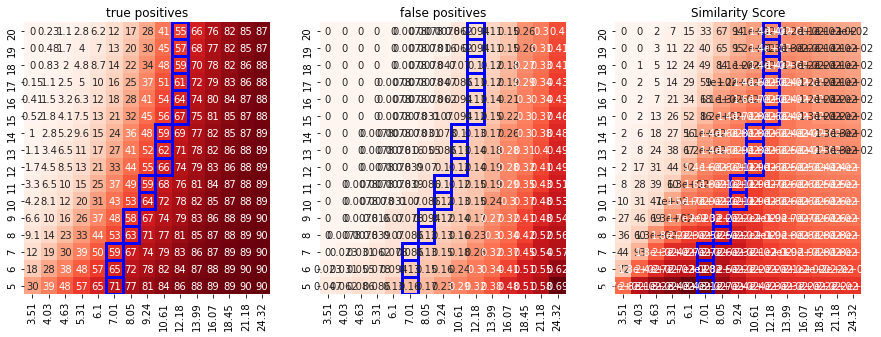

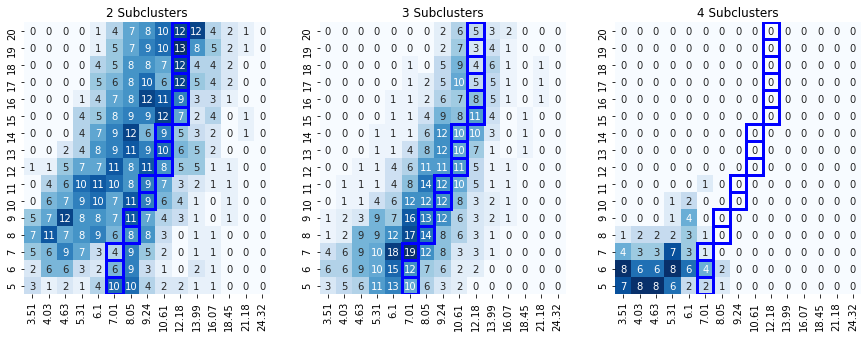

In [25]:
fig,axs = plt.subplots(nrows=1,ncols=3,figsize=(15,5))
sns.heatmap(tp_matr*100/len(XC),xticklabels=np.round(sigmas,2),yticklabels=np.flipud(np.round(thresholds)),annot=True,ax=axs[0],cbar=False,cmap='Reds');
sns.heatmap(fp_matr*100/len(XC),xticklabels=np.round(sigmas,2),yticklabels=np.flipud(np.round(thresholds)),annot=True,ax=axs[1],cbar=False,cmap='Reds');
sns.heatmap(sim_matr,xticklabels=np.round(sigmas,2),yticklabels=np.flipud(np.round(thresholds)),annot=True,ax=axs[2],cbar=False,cmap='Reds');
from matplotlib.patches import Rectangle


axs[0].set_title("true positives")
axs[1].set_title("false positives")
axs[2].set_title("Similarity Score")

for l in range(3):
    for i, j in enumerate(max_list[::-1]):
        axs[l].add_patch(Rectangle((j, i), 1, 1, fill=False, edgecolor='blue', lw=3)) 

        

plt.show()

fig,axs = plt.subplots(nrows=1,ncols=3,figsize=(15,5))
sns.heatmap(cl_2_matr,xticklabels=np.round(sigmas,2),yticklabels=np.flipud(np.round(thresholds)),annot=True,ax=axs[0],cbar=False,cmap='Blues');
sns.heatmap(cl_3_matr,xticklabels=np.round(sigmas,2),yticklabels=np.flipud(np.round(thresholds)),annot=True,ax=axs[1],cbar=False,cmap='Blues');
sns.heatmap(cl_4_matr,xticklabels=np.round(sigmas,2),yticklabels=np.flipud(np.round(thresholds)),annot=True,ax=axs[2],cbar=False,cmap='Blues');
from matplotlib.patches import Rectangle
axs[0].set_title("2 Subclusters")
axs[1].set_title("3 Subclusters")
axs[2].set_title("4 Subclusters")

for l in range(3):
    for i, j in enumerate(max_list[::-1]):
        axs[l].add_patch(Rectangle((j, i), 1, 1, fill=False, edgecolor='blue', lw=3))
print()       
plt.show()

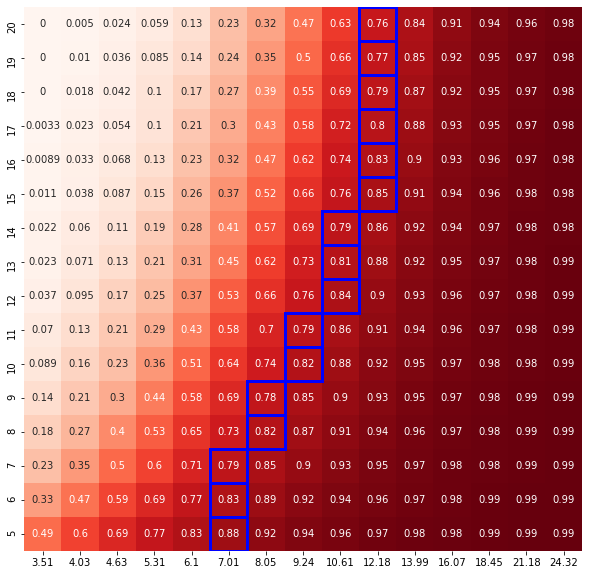

In [26]:
fig,axs = plt.subplots(nrows=1,ncols=1,figsize=(10,10))

sns.heatmap(F1_matr,xticklabels=np.round(sigmas,2),yticklabels=np.flipud(np.round(thresholds)),annot=True,ax = axs, cbar=False,cmap='Reds');
for l in range(3):
    for i, j in enumerate(max_list[::-1]):
        axs.add_patch(Rectangle((j, i), 1, 1, fill=False, edgecolor='blue', lw=3))

In [27]:
opt_sim = []
opt_n_cl = []
for i, j in enumerate(max_list[::-1]):
    #print(thresholds[::-1][i], sigmas[j], sim_matr[i,j])
    opt_sim.append(sim_matr[i,j])
    opt_n_cl.append(n_cl_matr[i,j])

AttributeError: 'Finder' object has no attribute 'sim_score_opt'

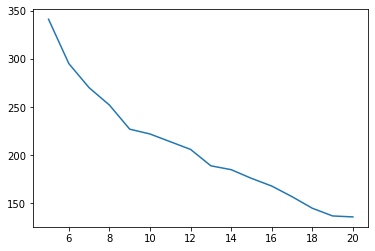

In [28]:
plt.plot(thresholds, opt_sim[::-1])
plt.plot(thresholds, FD.sim_score_opt)
plt.xlabel("threshold")
plt.ylabel("Similarity Score")
plt.legend(["Sim_threshold", "Sim_diag"])
plt.show()
plt.plot(thresholds, opt_n_cl[::-1], '*')
plt.xlabel("threshold")
plt.ylabel("Number of clusters")
plt.show()

In [ ]:
opt_sim = []
opt_n_cl = []

for i, j in enumerate(max_list[::-1]):
    #print(thresholds[::-1][i], sigmas[j], sim_matr[i,j])
    opt_sim.append(sim_matr[i,j])
    opt_n_cl.append(n_cl_matr[i,j])

opt_sim = np.array(opt_sim)
opt_n_cl = np.array(opt_n_cl)


plt.plot(thresholds,(opt_sim[::-1] - opt_sim.min())/(opt_sim.max() - opt_sim.min()) )
plt.xlabel("threshold")
plt.ylabel("Similarity Score")
#plt.yscale("log")
plt.show()


plt.plot(thresholds, (opt_n_cl[::-1] - opt_n_cl.min())/(opt_n_cl.max() - opt_n_cl.min()) , '*')
plt.xlabel("threshold")
plt.ylabel("Number of clusters")
# plt.yscale("log")
plt.show()

#a = (opt_n_cl[::-1] - opt_n_cl.min())/(opt_n_cl.max() - opt_n_cl.min()) 
a = (opt_sim[::-1] - opt_sim.min())/(opt_sim.max() - opt_sim.min())

ind = np.where(a<0.5)


#s = 6
#t = 7
t = ind[0][0]

s = max_list[t]

labels = get_labels(s,t,PS)

plot_clustering(G.XC, labels)
cc = subClustersPerRefCluster(labels, G.labels_groundtruth)


fig, ax = plt.subplots()
sns.histplot(data=cc, discrete=True, shrink=0.8)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_yticks([])
ax.set_xticks([])
ax.set_ylim(0, 25)
ax.set_xlim(0, 11)
ax.set_xticks(np.arange(10 + 1))
xlabs = [str(i) for i in np.arange(10 + 1)]
xlabs[-1] = ">= 10"
ax.set_xticklabels(xlabs)
ax.set_xlabel('Detected subclusters')
plt.show()

In [ ]:
# from Finder import Finder_1d_old

# FD_old = Finder_1d_old()
# AA = FD_old.fit(XC)

# plot_clustering(G.XC, AA)
# cc = subClustersPerRefCluster(AA, G.labels_groundtruth)


# fig, ax = plt.subplots()
# sns.histplot(data=cc, discrete=True, shrink=0.8)
# ax.set_xlabel("")
# ax.set_ylabel("")
# ax.set_yticks([])
# ax.set_xticks([])
# ax.set_ylim(0, 25)
# ax.set_xlim(0, 11)
# ax.set_xticks(np.arange(10 + 1))
# xlabs = [str(i) for i in np.arange(10 + 1)]
# xlabs[-1] = ">= 10"
# ax.set_xticklabels(xlabs)
# ax.set_xlabel('Detected subclusters')
# plt.show()

# for i in FD_old.phasespace:
#     print(i["sigma"])
# sigmas